## Cluster Comparison Metrics (with Mathematics)

### 1. **Convex Hull IoU**

- **Definition**: Measures the geometric intersection-over-union of the convex hulls of two point sets \( X \) and \( Y \).
- **Formula**:
  $$\text{IoU}(X, Y) = \frac{\text{Volume}(\text{Hull}(X) \cap \text{Hull}(Y))}{\text{Volume}(\text{Hull}(X) \cup \text{Hull}(Y))}$$
- **Interpretation**: Quantifies how much the convex outer boundaries of the two clusters intersect in space.

---

### 2. **Mahalanobis Distance**

- **Definition**: Measures the distance between the means of two distributions, scaled by their covariance (often pooled).
- **Formula**:
  $$D_M(X, Y) = \sqrt{(\mu_X - \mu_Y)^T \Sigma^{-1} (\mu_X - \mu_Y)}$$
  where:
  - $\mu_X, \mu_Y$ : means of clusters  $X$ , $Y$ 
  - $\Sigma$: pooled covariance matrix of both clusters
- **Interpretation**: Gives a scale-invariant measure of separation between cluster centres.

---

### 3. **Bhattacharyya Distance**

- **Definition**: Quantifies the similarity between two multivariate Gaussian distributions.
- **Formula**:
  $D_B(X, Y) = \frac{1}{8} (\mu_X - \mu_Y)^T \Sigma^{-1} (\mu_X - \mu_Y) + \frac{1}{2} \ln\left( \frac{\det \Sigma}{\sqrt{\det \Sigma_X \cdot \det \Sigma_Y}} \right)$
  where:
  - $\Sigma = \frac{1}{2} (\Sigma_X + \Sigma_Y)$
- **Interpretation**: Measures both the mean difference and the spread (covariance) difference — lower is more similar.

---

## nterpretation Table

| Metric                   | Value Range | Meaning (Low Value)            | Meaning (High Value)             |
|--------------------------|-------------|--------------------------------|----------------------------------|
| **Convex Hull IoU**      | $[0, 1]$  | No geometric overlap            | Strong spatial overlap           |
| **Mahalanobis Distance** | $[0, \infty)$ | Cluster means are close        | Cluster means are far apart      |
| **Bhattacharyya Distance** | $[0, \infty)$ | Distributions highly similar    | Distributions clearly separated  |

---

### Suggested Interpretation Thresholds

| Metric                   | Value       | Interpretation                                |
|--------------------------|-------------|-----------------------------------------------|
| Convex Hull IoU          | 0.0 – 0.2   | Minimal or no overlap                         |
|                          | 0.3 – 0.6   | Moderate geometric overlap                    |
|                          | > 0.7       | Strong overlap                                |
| Mahalanobis Distance     | < 1.5       | Clusters are close, high chance of overlap    |
|                          | 1.5 – 3.0   | Moderate separation                           |
|                          | > 3.0       | Clearly separated cluster centres             |
| Bhattacharyya Distance   | < 0.5       | High distributional overlap                   |
|                          | 0.5 – 1.5   | Moderate statistical separation               |
|                          | > 1.5       | Strong separation in both mean and spread     |


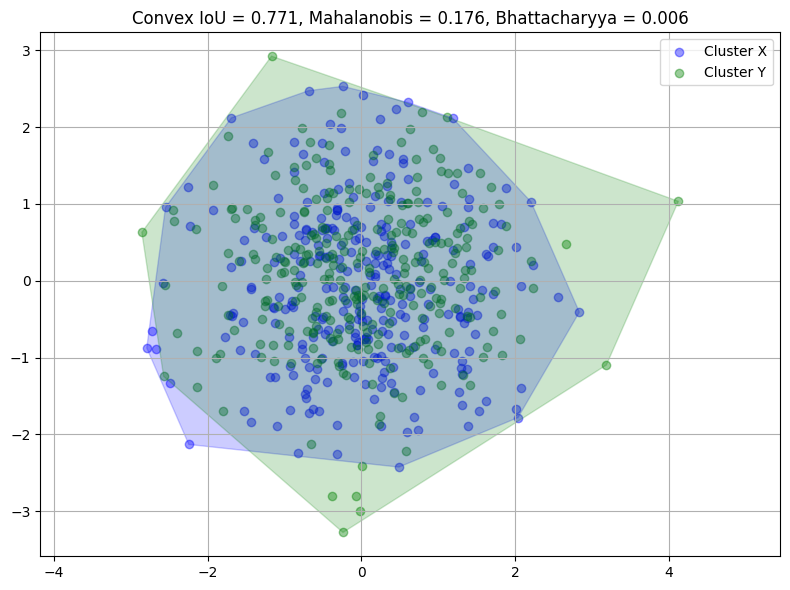

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Delaunay
from scipy.linalg import inv, det
from sklearn.datasets import make_blobs
from matplotlib.patches import Polygon
from matplotlib import cm
from sklearn.decomposition import PCA

# Generate 2D data for visualisation
X, _ = make_blobs(n_samples=300, centers=[(2, 0)], cluster_std=1.0, random_state=0)
Y, _ = make_blobs(n_samples=300, centers=[(2, 0)], cluster_std=1.0, random_state=1)

# Fit PCA to both datasets combined (preserve 2D here just for consistency)
pca = PCA(n_components=2)
XY_pca = pca.fit_transform(np.vstack((X, Y)))
X_pca = XY_pca[:300]
Y_pca = XY_pca[300:]

# Convex hull overlap (Monte Carlo estimation)
def get_bounding_box(X, Y):
    all_points = np.vstack([X, Y])
    return all_points.min(axis=0), all_points.max(axis=0)

def sample_uniform(mins, maxs, n_samples):
    return np.random.uniform(mins, maxs, (n_samples, len(mins)))

def in_hull(points, delaunay):
    return delaunay.find_simplex(points) >= 0

def convex_hull_iou(X, Y, n_samples=50000):
    hull_X = ConvexHull(X)
    hull_Y = ConvexHull(Y)
    del_X = Delaunay(X[hull_X.vertices])
    del_Y = Delaunay(Y[hull_Y.vertices])
    
    mins, maxs = get_bounding_box(X, Y)
    samples = sample_uniform(mins, maxs, n_samples)
    
    in_X = in_hull(samples, del_X)
    in_Y = in_hull(samples, del_Y)
    
    intersection = np.sum(in_X & in_Y)
    union = np.sum(in_X | in_Y)
    
    return intersection / union

# Mahalanobis distance
def mahalanobis_distance(X, Y):
    mu_X, mu_Y = X.mean(0), Y.mean(0)
    pooled_cov = np.cov(np.vstack((X, Y)).T)
    inv_cov = inv(pooled_cov)
    delta = mu_X - mu_Y
    return np.sqrt(delta.T @ inv_cov @ delta)

# Bhattacharyya distance
def bhattacharyya_distance(X, Y):
    mu_X, mu_Y = X.mean(0), Y.mean(0)
    cov_X = np.cov(X.T)
    cov_Y = np.cov(Y.T)
    cov_avg = 0.5 * (cov_X + cov_Y)
    inv_cov_avg = inv(cov_avg)
    term1 = 0.125 * ((mu_X - mu_Y).T @ inv_cov_avg @ (mu_X - mu_Y))
    term2 = 0.5 * np.log(det(cov_avg) / np.sqrt(det(cov_X) * det(cov_Y)))
    return term1 + term2

# Compute measures
iou = convex_hull_iou(X_pca, Y_pca)
mahal = mahalanobis_distance(X_pca, Y_pca)
bhat = bhattacharyya_distance(X_pca, Y_pca)

# Visualisation
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.4, label="Cluster X", color="blue")
ax.scatter(Y_pca[:, 0], Y_pca[:, 1], alpha=0.4, label="Cluster Y", color="green")

# Convex hulls
hull_X = ConvexHull(X_pca)
hull_Y = ConvexHull(Y_pca)
poly_X = Polygon(X_pca[hull_X.vertices], color='blue', alpha=0.2)
poly_Y = Polygon(Y_pca[hull_Y.vertices], color='green', alpha=0.2)
ax.add_patch(poly_X)
ax.add_patch(poly_Y)

ax.legend()
ax.set_title(f"Convex IoU = {iou:.3f}, Mahalanobis = {mahal:.3f}, Bhattacharyya = {bhat:.3f}")
plt.tight_layout()
plt.grid(True)
plt.axis("equal")
plt.show()


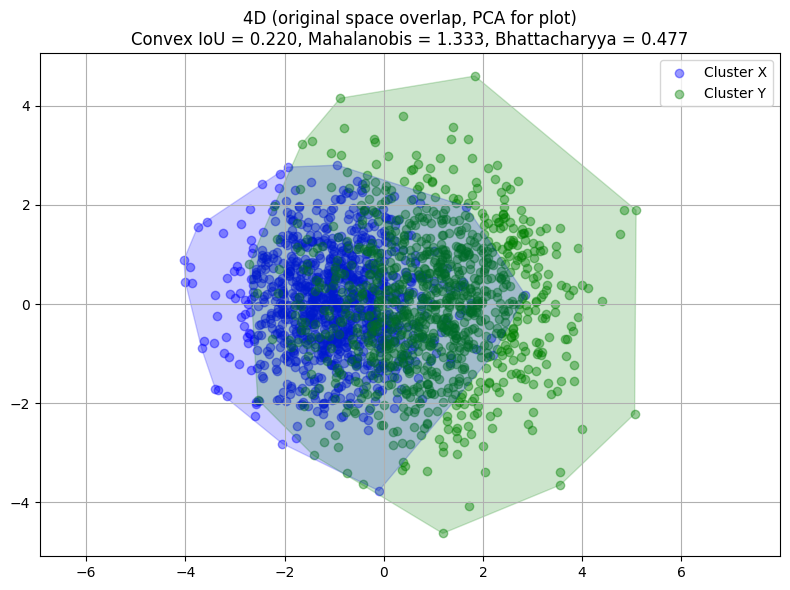

(0.22012229016120066, 1.3327128187145834, 0.47659817012117445)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Delaunay
from scipy.linalg import inv, det
from matplotlib.patches import Polygon
from sklearn.decomposition import PCA

def visualise_and_compare_clusters(X, Y, pca_components=2, n_samples=50000, title_prefix=""):
    def get_bounding_box(A, B):
        all_points = np.vstack([A, B])
        return all_points.min(axis=0), all_points.max(axis=0)

    def sample_uniform(mins, maxs, n_samples):
        return np.random.uniform(mins, maxs, (n_samples, len(mins)))

    def in_hull(points, delaunay):
        return delaunay.find_simplex(points) >= 0

    def convex_hull_iou_original_space(A, B, n_samples):
        hull_A = ConvexHull(A)
        hull_B = ConvexHull(B)
        del_A = Delaunay(A[hull_A.vertices])
        del_B = Delaunay(B[hull_B.vertices])
        mins, maxs = get_bounding_box(A, B)
        samples = sample_uniform(mins, maxs, n_samples)
        in_A = in_hull(samples, del_A)
        in_B = in_hull(samples, del_B)
        intersection = np.sum(in_A & in_B)
        union = np.sum(in_A | in_B)
        return intersection / union

    def mahalanobis_distance(A, B):
        mu_A, mu_B = A.mean(0), B.mean(0)
        pooled_cov = np.cov(np.vstack((A, B)).T)
        inv_cov = inv(pooled_cov)
        delta = mu_A - mu_B
        return np.sqrt(delta.T @ inv_cov @ delta)

    def bhattacharyya_distance(A, B):
        mu_A, mu_B = A.mean(0), B.mean(0)
        cov_A = np.cov(A.T)
        cov_B = np.cov(B.T)
        cov_avg = 0.5 * (cov_A + cov_B)
        inv_cov_avg = inv(cov_avg)
        term1 = 0.125 * ((mu_A - mu_B).T @ inv_cov_avg @ (mu_A - mu_B))
        term2 = 0.5 * np.log(det(cov_avg) / np.sqrt(det(cov_A) * det(cov_B)))
        return term1 + term2

    # Compute metrics in original space
    iou = convex_hull_iou_original_space(X, Y, n_samples=n_samples)
    mahal = mahalanobis_distance(X, Y)
    bhat = bhattacharyya_distance(X, Y)

    # PCA projection for visualisation
    pca = PCA(n_components=pca_components)
    XY_pca = pca.fit_transform(np.vstack((X, Y)))
    X_pca = XY_pca[:len(X)]
    Y_pca = XY_pca[len(X):]

    # Visualisation
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.4, label="Cluster X", color="blue")
    ax.scatter(Y_pca[:, 0], Y_pca[:, 1], alpha=0.4, label="Cluster Y", color="green")

    hull_X = ConvexHull(X_pca)
    hull_Y = ConvexHull(Y_pca)
    poly_X = Polygon(X_pca[hull_X.vertices], color='blue', alpha=0.2)
    poly_Y = Polygon(Y_pca[hull_Y.vertices], color='green', alpha=0.2)
    ax.add_patch(poly_X)
    ax.add_patch(poly_Y)

    ax.legend()
    ax.set_title(f"{title_prefix}Convex IoU = {iou:.3f}, Mahalanobis = {mahal:.3f}, Bhattacharyya = {bhat:.3f}")
    plt.tight_layout()
    plt.grid(True)
    plt.axis("equal")
    plt.show()

    return iou, mahal, bhat

# Example usage with 4D data
from sklearn.datasets import make_blobs
X_4d, _ = make_blobs(n_samples=1000, centers=[(2, 0, 0, 0)], cluster_std=1.0, random_state=0)
Y_4d, _ = make_blobs(n_samples=1000, centers=[(2, 0, 2, 0)], cluster_std=1.3, random_state=1)


visualise_and_compare_clusters(X_4d, Y_4d, title_prefix="4D (original space overlap, PCA for plot)\n", n_samples=50000)

